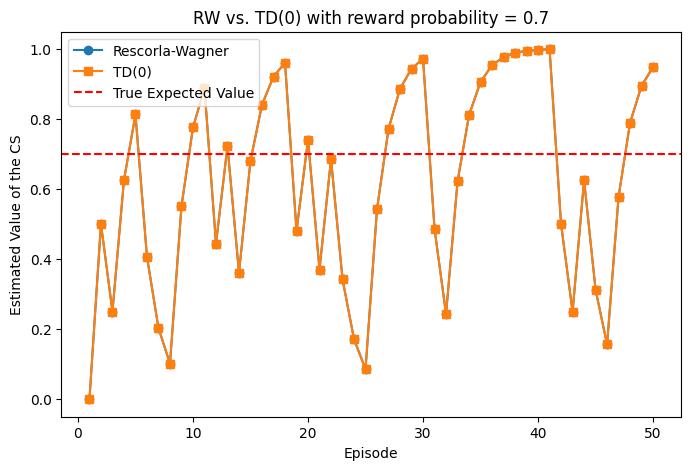

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def compare_rw_td(prob_reward=0.7, num_episodes=50, alpha=0.5, gamma=1.0, seed=None):
    """
    Compare Rescorla-Wagner (RW) model to a basic TD(0) model
    in a simple 2-step classical conditioning environment
    with probabilistic reward.
    
    Args:
        prob_reward (float): Probability of receiving the US (reward = 1).
        num_episodes (int): Number of trials (episodes).
        alpha (float): Learning rate for both RW and TD(0).
        gamma (float): Discount factor for TD(0).
        seed (int): Random seed for reproducibility.
    """

    # Set random seed for reproducible results
    rng = np.random.default_rng(seed)

    # ---------------------------
    # 1) Initialize values
    # ---------------------------
    # Rescorla-Wagner: single V for the CS
    V_RW = 0.0

    # TD(0): We'll have two states: State 0 (the CS), State 1 (post-CS).
    V_TD = {0: 0.0, 1: 0.0}

    # Lists to track estimates of the CS value across episodes
    rw_values = []
    td_values = []

    # ---------------------------
    # 2) Simulation loop
    # ---------------------------
    for ep in range(num_episodes):
        # Whether reward is delivered this episode
        # US occurs with probability = prob_reward
        reward = 1.0 if rng.random() < prob_reward else 0.0

        # --------- Rescorla-Wagner Update ---------
        # RW prediction error = R - V_RW
        prediction_error_rw = reward - V_RW
        V_RW += alpha * prediction_error_rw

        # --------- TD(0) Update ---------
        # Episode flow:
        #   State 0 (observe CS) -> (reward occurs with prob_reward) -> State 1 -> end
        #
        # TD update for State 0
        # r = reward (0 or 1), next state = State 1
        V_TD[0] = V_TD[0] + alpha * (reward + gamma * V_TD[1] - V_TD[0])
        # State 1 is terminal in this toy example, so there's no further update from State 1

        # Store the updated value for plotting
        rw_values.append(V_RW)
        td_values.append(V_TD[0])

    return rw_values, td_values

def run_and_plot():
    """
    Run the comparison and plot the results.
    """
    # Simulation parameters
    prob_reward = 0.7
    num_episodes = 50
    alpha = 0.5
    gamma = 1.0
    seed = 42  # for reproducible random reward sequence

    # Run simulation
    rw_vals, td_vals = compare_rw_td(prob_reward, num_episodes, alpha, gamma, seed)

    # Plot
    episodes = range(1, num_episodes + 1)
    plt.figure(figsize=(8,5))
    plt.plot(episodes, rw_vals, 'o-', label='Rescorla-Wagner')
    plt.plot(episodes, td_vals, 's-', label='TD(0)')
    plt.axhline(prob_reward, color='red', linestyle='--', label='True Expected Value')
    plt.xlabel('Episode')
    plt.ylabel('Estimated Value of the CS')
    plt.title(f'RW vs. TD(0) with reward probability = {prob_reward}')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    run_and_plot()


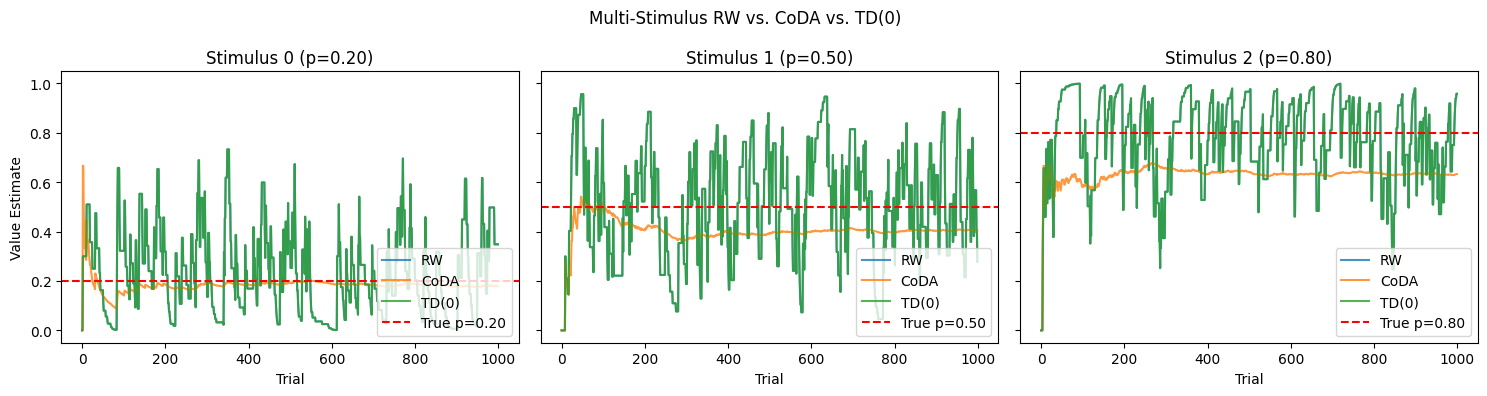

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1) Environment with Multiple Stimuli
# ------------------------------------------------
class MultiStimulusEnvironment:
    """
    Environment that presents one stimulus (CS) per trial, chosen randomly.
    Each stimulus has an associated reward probability.
    """
    def __init__(self, reward_probs, seed=None):
        """
        Args:
            reward_probs (list or np.array): Probabilities of reward for each stimulus.
            seed (int): Optional random seed for reproducibility.
        """
        self.reward_probs = np.array(reward_probs)
        self.n_stimuli = len(reward_probs)
        self.rng = np.random.default_rng(seed)

    def reset(self):
        # For a single-step environment, reset can be trivial
        pass

    def step(self):
        """
        Returns (stimulus_index, reward).
        - stimulus_index (int): which stimulus is presented this trial
        - reward (0 or 1)
        """
        # Randomly pick which stimulus is presented
        stimulus_index = self.rng.integers(0, self.n_stimuli)
        # Deliver reward with that stimulus's probability
        if self.rng.random() < self.reward_probs[stimulus_index]:
            reward = 1.0
        else:
            reward = 0.0

        return stimulus_index, reward


# ------------------------------------------------
# 2) Rescorla-Wagner Model for Multiple Stimuli
# ------------------------------------------------
class RescorlaWagnerMulti:
    """
    A Rescorla-Wagner learner that has a separate associative strength for each stimulus.
    """
    def __init__(self, n_stimuli, alpha=0.5, init_value=0.0):
        """
        Args:
            n_stimuli (int): Number of stimuli.
            alpha (float): RW learning rate.
            init_value (float): Initial value for all stimuli.
        """
        self.alpha = alpha
        # Create a value array for N stimuli
        self.V = np.full(n_stimuli, init_value, dtype=float)

    def update(self, stimulus_idx, reward):
        """
        Update the associative strength for the given stimulus using RW:
            V[stimulus_idx] <- V[stimulus_idx] + alpha * (reward - V[stimulus_idx])
        Args:
            stimulus_idx (int): Index of the stimulus presented.
            reward (float): Observed reward (0 or 1 in this example).
        """
        prediction_error = reward - self.V[stimulus_idx]
        self.V[stimulus_idx] += self.alpha * prediction_error

# ------------------------------------------------
# 3) Rescorla-Wagner Model for Multiple Stimuli
# ------------------------------------------------
class CoDAMulti:
    """
    A Contingency-dependent state augmentation learner that has a separate associative strength for each stimulus.
    """
    def __init__(self, n_stimuli, alpha=0.5, init_value=0.0):
        """
        Args:
            n_stimuli (int): Number of stimuli.
            alpha (float): RW learning rate.
            init_value (float): Initial value for all stimuli.
        """
        self.alpha = alpha
        # Create a value array for N stimuli
        self.V = np.full(n_stimuli, init_value, dtype=float)
        self.A = np.full(n_stimuli, init_value, dtype=float) # stimulus, reward
        self.B = np.full(n_stimuli, init_value, dtype=float) # stimulus, nonreward
        self.C = np.full(n_stimuli, init_value, dtype=float) # non stimmulus, reward
        self.n_stimuli = n_stimuli

    def get_specificity(self, A, B):
        return A/(A+B) if (A+B) > 0 else 0.0
    def get_sensitivity(self, A, C):
        return A/(A+C) if (A+C) > 0 else 0.0
    def get_F1(self, specificity, sensitivity):
       # F1 score
        if (specificity + sensitivity) > 0:
            f1 = 2 * (specificity * sensitivity) / (specificity + sensitivity)
        else:
            f1 = 0.0
        return f1     

    def update(self, stimulus_idx, reward):
        """
        Update the associative strength for the given stimulus using RW:
            V[stimulus_idx] <- V[stimulus_idx] + alpha * (reward - V[stimulus_idx])
        Args:
            stimulus_idx (int): Index of the stimulus presented.
            reward (float): Observed reward (0 or 1 in this example).
        """
        # self.A[stimulus_idx]
        mask = np.arange(len(self.B)) != stimulus_idx
        if reward == 1: 
            self.A[stimulus_idx] += 1
            self.C[mask] += 1
        elif reward == 0: 
            self.B[stimulus_idx] += 1

        for stim in range(self.n_stimuli):
            specificity = self.get_specificity(self.A[stim], self.B[stim])
            sensitivity = self.get_sensitivity(self.A[stim], self.C[stim])
            contingency = self.get_F1(specificity, sensitivity)
            self.V[stim] = contingency
        # prediction_error = reward - self.V[stimulus_idx]
        # self.V[stimulus_idx] += self.alpha * prediction_error


# ------------------------------------------------
# 4) TD(0) Model for Multiple Stimuli
# ------------------------------------------------
class TDLearnerMulti:
    """
    A simple TD(0) learner, one value per stimulus. 
    In a single-step environment (episode ends immediately), 
    this is quite similar to Rescorla-Wagner.
    """
    def __init__(self, n_stimuli, alpha=0.5, gamma=1.0, init_value=0.0):
        """
        Args:
            n_stimuli (int): Number of stimuli.
            alpha (float): Learning rate.
            gamma (float): Discount factor.
            init_value (float): Initial value for all stimuli.
        """
        self.alpha = alpha
        self.gamma = gamma
        self.V = np.full(n_stimuli, init_value, dtype=float)

    def update(self, stimulus_idx, reward):
        """
        Single-step TD(0) update for the chosen stimulus:
            V[s] <- V[s] + alpha * (reward - V[s]),
        because the next state is terminal (no subsequent value).
        Args:
            stimulus_idx (int): Index of the stimulus presented.
            reward (float): 0 or 1.
        """
        # In a single-step environment, the next state is terminal,
        # so the next state's value is effectively 0.
        td_error = reward - self.V[stimulus_idx]
        self.V[stimulus_idx] += self.alpha * td_error


# ------------------------------------------------
# 5) Running the Experiment
# ------------------------------------------------
def run_experiment(n_stimuli=3, reward_probs=None, num_trials=200, alpha=0.3, gamma=1.0, seed=None):
    """
    Run a multi-stimulus experiment where each trial picks one of n_stimuli
    (each with its own reward probability), then compares Rescorla-Wagner and TD(0).

    Args:
        n_stimuli (int): Number of stimuli (only used if reward_probs is None).
        reward_probs (list or array): Probability of reward for each stimulus.
                                      If None, randomly generate them.
        num_trials (int): How many trials to run.
        alpha (float): Learning rate for both RW and TD.
        gamma (float): Discount factor for TD.
        seed (int): Random seed.

    Returns:
        - rw_history: (num_trials, n_stimuli) array of RW's value estimates over time
        - td_history: (num_trials, n_stimuli) array of TD's value estimates over time
        - actual_probs: list or array of the actual reward probabilities used
    """
    rng = np.random.default_rng(seed)

    # If no reward_probs provided, randomly generate between 0.0 and 1.0
    if reward_probs is None:
        reward_probs = rng.random(n_stimuli)  # random float in [0, 1)
    else:
        # Make sure it's numpy array
        reward_probs = np.array(reward_probs)

    env = MultiStimulusEnvironment(reward_probs, seed=seed)

    # Instantiate models
    rw_model = RescorlaWagnerMulti(n_stimuli=len(reward_probs), alpha=alpha, init_value=0.0)
    coda_model = CoDAMulti(n_stimuli=len(reward_probs), alpha=alpha, init_value=0.0)
    td_model = TDLearnerMulti(n_stimuli=len(reward_probs), alpha=alpha, gamma=gamma, init_value=0.0)

    # To store values after each trial
    rw_history = np.zeros((num_trials, len(reward_probs)))
    coda_history = np.zeros((num_trials, len(reward_probs)))
    td_history = np.zeros((num_trials, len(reward_probs)))

    for t in range(num_trials):
        # Step environment: get a stimulus and reward
        stimulus_idx, reward = env.step()

        # Update both models
        rw_model.update(stimulus_idx, reward)
        coda_model.update(stimulus_idx, reward)
        td_model.update(stimulus_idx, reward)

        # Record current estimates
        rw_history[t, :] = rw_model.V
        coda_history[t,:] = coda_model.V
        td_history[t, :] = td_model.V

    return rw_history, coda_history, td_history, reward_probs


def main():
    # Example with 3 stimuli, each with a different reward probability
    reward_probs = [0.2, 0.5, 0.8]  # e.g., 20%, 50%, 80%
    # reward_probs = [0.2, 0.5]  # e.g., 20%, 50%, 80%
    num_trials = 1000
    alpha = 0.3
    gamma = 1.0
    seed = 42

    rw_vals, coda_vals, td_vals, true_probs = run_experiment(
        n_stimuli=3,
        reward_probs=reward_probs,
        num_trials=num_trials,
        alpha=alpha,
        gamma=gamma,
        seed=seed
    )

    # Plot: for each stimulus, show the RW and TD learning curves
    n_stimuli = len(true_probs)
    x = np.arange(num_trials)

    fig, axes = plt.subplots(1, n_stimuli, figsize=(15, 4), sharey=True)
    if n_stimuli == 1:
        axes = [axes]  # so we can iterate over axes if there's only 1 stimulus

    for i in range(n_stimuli):
        ax = axes[i]
        ax.plot(x, rw_vals[:, i], label="RW", alpha=0.8)
        ax.plot(x, coda_vals[:, i], label="CoDA", alpha=0.8)
        ax.plot(x, td_vals[:, i], label="TD(0)", alpha=0.8)
        ax.axhline(true_probs[i], color='red', linestyle='--', label="True p={:.2f}".format(true_probs[i]))
        ax.set_title(f"Stimulus {i} (p={true_probs[i]:.2f})")
        ax.set_xlabel("Trial")
        if i == 0:
            ax.set_ylabel("Value Estimate")
        ax.legend(loc="lower right")

    plt.suptitle("Multi-Stimulus RW vs. CoDA vs. TD(0)")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


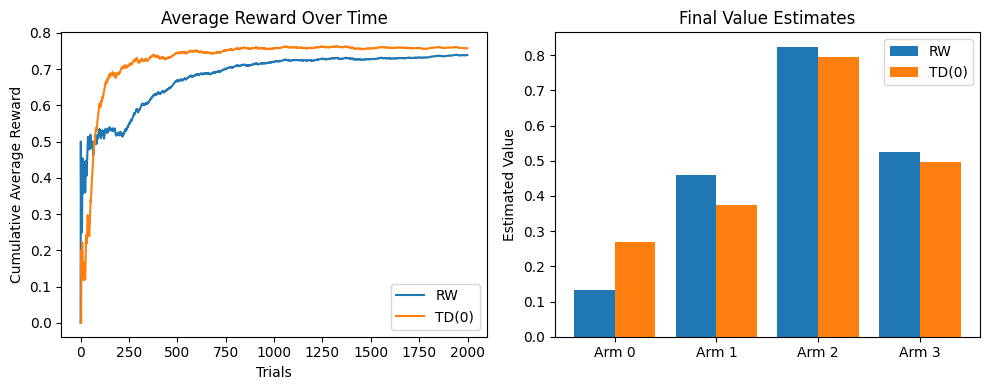

True reward probabilities: [0.2, 0.5, 0.8, 0.8]
RW final estimates:        [0.1324689  0.45951047 0.82379176 0.52398652]
TD(0) final estimates:     [0.26900011 0.37477366 0.79351625 0.49729636]

Mean reward (RW):   0.739
Mean reward (TD(0)): 0.758


In [16]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1) Multi-Armed Bandit Environment
# ------------------------------------------------------
class NArmedBandit:
    """
    An N-armed bandit with Bernoulli rewards.
    Each arm i has some reward probability p[i].
    """
    def __init__(self, reward_probs, seed=None):
        """
        Args:
            reward_probs (list or array): Probability of reward for each arm.
            seed (int): Random seed for reproducibility (optional).
        """
        self.reward_probs = np.array(reward_probs, dtype=float)
        self.n_arms = len(reward_probs)
        self.rng = np.random.default_rng(seed)

    def step(self, action):
        """
        Pull the chosen arm and get a stochastic reward (0 or 1).
        """
        # Bernoulli reward with probability = reward_probs[action]
        reward = 1.0 if self.rng.random() < self.reward_probs[action] else 0.0
        return reward


# ------------------------------------------------------
# 2) Rescorla-Wagner Agent
# ------------------------------------------------------
class RescorlaWagnerAgent:
    """
    Rescorla-Wagner agent for an N-armed bandit.
    Maintains a value estimate V[i] for each arm.
    Uses epsilon-greedy for selection.
    """
    def __init__(self, n_arms, alpha=0.1, epsilon=0.1, init_value=0.0):
        """
        Args:
            n_arms (int): Number of arms.
            alpha (float): Learning rate for RW update.
            epsilon (float): Epsilon for epsilon-greedy exploration.
            init_value (float): Initial value for all arms.
        """
        self.n_arms = n_arms
        self.alpha = alpha
        self.epsilon = epsilon
        self.V = np.full(n_arms, init_value, dtype=float)

    def select_action(self):
        """
        Epsilon-greedy policy based on current value estimates V.
        """
        if np.random.rand() < self.epsilon:
            # Explore: choose random arm
            return np.random.randint(0, self.n_arms)
        else:
            # Exploit: choose best arm
            return np.argmax(self.V)

    def update(self, chosen_arm, reward):
        """
        Rescorla-Wagner update for the chosen arm:
          V[chosen_arm] += alpha * (reward - V[chosen_arm])
        """
        prediction_error = reward - self.V[chosen_arm]
        self.V[chosen_arm] += self.alpha * prediction_error


# ------------------------------------------------------
# 3) TD(0) Agent (Single-step)
# ------------------------------------------------------
class TDAgent:
    """
    A simple TD(0) agent for an N-armed bandit (single-step).
    We store Q[i] for each arm. The update is very similar to RW,
    because in a bandit, there's no next state to bootstrap from.
    But we keep the Q-learning style notation.
    """
    def __init__(self, n_arms, alpha=0.1, gamma=1.0, epsilon=0.1, init_value=0.0):
        """
        Args:
            n_arms (int): Number of arms.
            alpha (float): Learning rate for the TD update.
            gamma (float): Discount factor. Typically 1 or 0 for a one-step bandit.
            epsilon (float): Epsilon for epsilon-greedy exploration.
            init_value (float): Initial Q-value for all arms.
        """
        self.n_arms = n_arms
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = np.full(n_arms, init_value, dtype=float)

    def select_action(self):
        """
        Epsilon-greedy policy based on Q-values.
        """
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.n_arms)
        else:
            return np.argmax(self.Q)

    def update(self, chosen_arm, reward):
        """
        TD(0) one-step update for the chosen action:
            Q[chosen_arm] += alpha * (reward + gamma*0 - Q[chosen_arm])
        Because there's no next state to bootstrap from in a bandit.
        """
        td_error = reward - self.Q[chosen_arm]  # gamma*0 omitted
        self.Q[chosen_arm] += self.alpha * td_error


# ------------------------------------------------------
# 4) Run a Simulation
# ------------------------------------------------------
def run_simulation(env, agent, n_steps=1000):
    """
    Runs a bandit simulation with the given environment and agent.

    Args:
        env (NArmedBandit): The bandit environment.
        agent: Either RescorlaWagnerAgent or TDAgent.
        n_steps (int): Number of trials (arm pulls).

    Returns:
        rewards (list): Rewards obtained on each trial.
        estimates (list): Value/Q estimates after each step (shape: [n_steps, n_arms]).
    """
    rewards = []
    estimates = []

    for t in range(n_steps):
        arm = agent.select_action()
        reward = env.step(arm)
        agent.update(arm, reward)
        
        rewards.append(reward)
        # Store a copy of current estimates
        if hasattr(agent, 'V'):
            estimates.append(agent.V.copy())
        else:
            estimates.append(agent.Q.copy())

    return np.array(rewards), np.array(estimates)


# ------------------------------------------------------
# 5) Example Usage & Comparison
# ------------------------------------------------------
if __name__ == "__main__":
    # Example: up to 4-armed bandit
    # Let's define 4 arms with different reward probabilities
    reward_probs = [0.2, 0.5, 0.8, 0.8]  # e.g., arms 0,1,2,3
    n_arms = len(reward_probs)
    bandit_env = NArmedBandit(reward_probs=reward_probs, seed=42)

    # Create two different agents
    # 1) Rescorla-Wagner
    rw_agent = RescorlaWagnerAgent(n_arms=n_arms, alpha=0.1, epsilon=0.1)
    # 2) TD(0)
    td_agent = TDAgent(n_arms=n_arms, alpha=0.1, gamma=1.0, epsilon=0.1)

    # Number of trials to simulate
    n_steps = 2000

    # Run the simulation for each agent
    rw_rewards, rw_estimates = run_simulation(bandit_env, rw_agent, n_steps)
    
    # Re-seed (or re-instantiate environment) for a fair comparison 
    bandit_env2 = NArmedBandit(reward_probs=reward_probs, seed=42)
    td_rewards, td_estimates = run_simulation(bandit_env2, td_agent, n_steps)

    # Compare average reward over time
    cum_rw = np.cumsum(rw_rewards) / (np.arange(n_steps) + 1)
    cum_td = np.cumsum(td_rewards) / (np.arange(n_steps) + 1)
    
    # Plotting
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10,4))
    
    # Plot cumulative reward
    plt.subplot(1,2,1)
    plt.plot(cum_rw, label="RW")
    plt.plot(cum_td, label="TD(0)")
    plt.xlabel("Trials")
    plt.ylabel("Cumulative Average Reward")
    plt.title("Average Reward Over Time")
    plt.legend()

    # Plot final learned value estimates
    plt.subplot(1,2,2)
    x = np.arange(n_arms)
    plt.bar(x - 0.2, rw_agent.V if hasattr(rw_agent, 'V') else rw_agent.Q, 0.4, label="RW")
    plt.bar(x + 0.2, td_agent.Q if hasattr(td_agent, 'Q') else td_agent.V, 0.4, label="TD(0)")
    plt.axhline(0, color='black', linewidth=0.5)
    plt.xticks(x, [f"Arm {i}" for i in range(n_arms)])
    plt.ylabel("Estimated Value")
    plt.title("Final Value Estimates")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print final performance
    print("True reward probabilities:", reward_probs)
    print("RW final estimates:       ", rw_agent.V if hasattr(rw_agent, 'V') else rw_agent.Q)
    print("TD(0) final estimates:    ", td_agent.Q if hasattr(td_agent, 'Q') else td_agent.V)
    print(f"\nMean reward (RW):   {rw_rewards.mean():.3f}")
    print(f"Mean reward (TD(0)): {td_rewards.mean():.3f}")


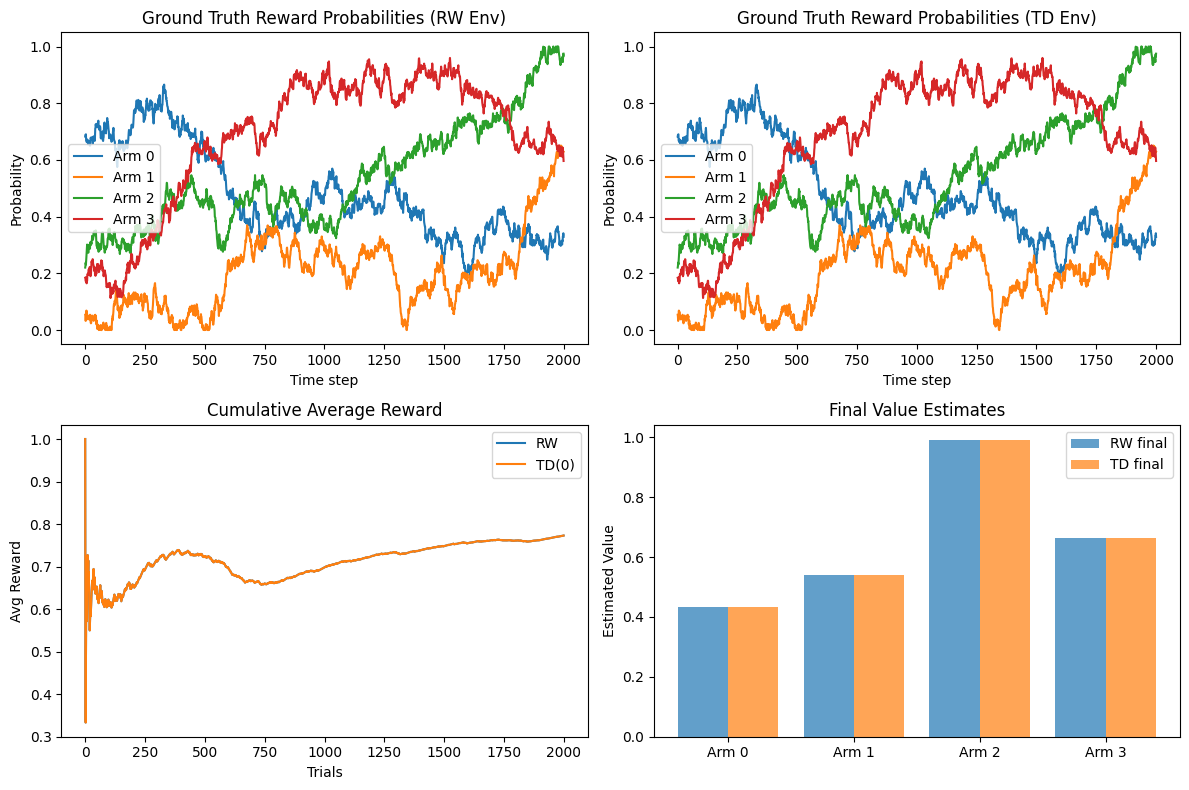

[RW] Mean reward: 0.773
[TD] Mean reward: 0.773
RW final estimates: [0.43403703 0.53968409 0.99189827 0.66428689]
TD final estimates: [0.43403703 0.53968409 0.99189827 0.66428689]


In [18]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 1) Drifting N-Armed Bandit Environment
# ----------------------------------------------------
class DriftingNArmedBandit:
    """
    An N-armed bandit where each arm's reward probability drifts over time
    via a random walk.
    """
    def __init__(self, n_arms=4, drift_scale=0.01, seed=None):
        """
        Args:
            n_arms (int): Number of arms.
            drift_scale (float): Std dev for the Gaussian random walk step.
            seed (int): Optional random seed.
        """
        self.n_arms = n_arms
        self.drift_scale = drift_scale
        self.rng = np.random.default_rng(seed)

        # Initialize each arm's probability randomly in [0,1]
        self.reward_probs = self.rng.random(n_arms)

    def step(self, action):
        """
        1) Sample reward from Bernoulli with probability = reward_probs[action].
        2) Drift each arm's probability for the next step.
        3) Return the reward.
        """
        # 1) Reward sample
        p = self.reward_probs[action]
        reward = 1.0 if self.rng.random() < p else 0.0

        # 2) Random walk update for each arm
        self.reward_probs += self.rng.normal(0, self.drift_scale, size=self.n_arms)
        # Clip to [0,1]
        np.clip(self.reward_probs, 0, 1, out=self.reward_probs)

        return reward


# ----------------------------------------------------
# 2) Rescorla-Wagner Agent
# ----------------------------------------------------
class RescorlaWagnerAgent:
    def __init__(self, n_arms, alpha=0.1, epsilon=0.1, init_value=0.0, seed=None):
        """
        Args:
            n_arms (int): Number of arms.
            alpha (float): Learning rate for RW.
            epsilon (float): Epsilon for epsilon-greedy exploration.
            init_value (float): Initial estimated value.
            seed (int): Random seed.
        """
        self.n_arms = n_arms
        self.alpha = alpha
        self.epsilon = epsilon
        self.V = np.full(n_arms, init_value, dtype=float)
        self.rng = np.random.default_rng(seed)

    def select_action(self):
        """
        Epsilon-greedy policy based on self.V.
        """
        if self.rng.random() < self.epsilon:
            return self.rng.integers(0, self.n_arms)
        else:
            return np.argmax(self.V)

    def update(self, arm, reward):
        """
        V[arm] <- V[arm] + alpha * (reward - V[arm])
        """
        prediction_error = reward - self.V[arm]
        self.V[arm] += self.alpha * prediction_error


# ----------------------------------------------------
# 3) TD(0) Agent (Single-step)
# ----------------------------------------------------
class TDAgent:
    """
    A simple one-step TD agent for a bandit (essentially identical to RW in a single-step).
    """
    def __init__(self, n_arms, alpha=0.1, gamma=1.0, epsilon=0.1, init_value=0.0, seed=None):
        self.n_arms = n_arms
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = np.full(n_arms, init_value, dtype=float)
        self.rng = np.random.default_rng(seed)

    def select_action(self):
        if self.rng.random() < self.epsilon:
            return self.rng.integers(0, self.n_arms)
        else:
            return np.argmax(self.Q)

    def update(self, arm, reward):
        td_error = reward - self.Q[arm]
        self.Q[arm] += self.alpha * td_error


# ----------------------------------------------------
# 4) Simulation Function
# ----------------------------------------------------
def run_simulation(env, agent, n_steps=1000):
    """
    Run a bandit simulation for n_steps. 
    Also track the environment's reward probabilities over time.

    Returns:
        rewards (ndarray): shape (n_steps,) -> reward per step
        estimates (ndarray): shape (n_steps, n_arms) -> agent's estimates each step
        true_probs (ndarray): shape (n_steps+1, n_arms) -> ground truth reward probs each step
    """
    rewards = np.zeros(n_steps, dtype=float)
    n_arms = env.n_arms

    # We'll store the agent's estimates after each step, plus the env's reward probs
    estimates = np.zeros((n_steps, n_arms))
    
    # true_probs will store environment's probabilities at each step:
    # We'll store the initial probabilities at index 0, then after each step for indices 1..n_steps
    true_probs = np.zeros((n_steps + 1, n_arms))
    true_probs[0, :] = env.reward_probs

    for t in range(n_steps):
        arm = agent.select_action()
        reward = env.step(arm)
        agent.update(arm, reward)

        rewards[t] = reward

        # record agent's current estimates
        if hasattr(agent, 'V'):
            estimates[t, :] = agent.V
        else:
            estimates[t, :] = agent.Q

        # record environment's new probabilities after drift
        true_probs[t + 1, :] = env.reward_probs

    return rewards, estimates, true_probs


# ----------------------------------------------------
# 5) Main Demo/Comparison
# ----------------------------------------------------
if __name__ == "__main__":

    # Number of arms
    n_arms = 4
    # Drifting scale
    drift_scale = 0.01
    # Number of trials
    n_steps = 2000
    # Seed for reproducible drifts
    env_seed = 123

    # 1) Instantiate the environment
    env1 = DriftingNArmedBandit(n_arms=n_arms, drift_scale=drift_scale, seed=env_seed)

    # 2) Create the Rescorla-Wagner agent
    rw_agent = RescorlaWagnerAgent(n_arms=n_arms, alpha=0.1, epsilon=0.1, seed=42)

    # 3) Run simulation with the RW agent
    rw_rewards, rw_estimates, rw_probs = run_simulation(env1, rw_agent, n_steps)

    # 4) TD(0) agent, run on a separate environment (same drift path)
    env2 = DriftingNArmedBandit(n_arms=n_arms, drift_scale=drift_scale, seed=env_seed)
    td_agent = TDAgent(n_arms=n_arms, alpha=0.1, gamma=1.0, epsilon=0.1, seed=42)
    td_rewards, td_estimates, td_probs = run_simulation(env2, td_agent, n_steps)

    # Compute cumulative average reward
    rw_cumavg = np.cumsum(rw_rewards) / (np.arange(n_steps) + 1)
    td_cumavg = np.cumsum(td_rewards) / (np.arange(n_steps) + 1)

    # --------------- PLOTTING ---------------

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    # (1) Plot the environment's drift over time (for the RW environment)
    #     We'll show all arms
    for arm_i in range(n_arms):
        axes[0].plot(rw_probs[:, arm_i], label=f"Arm {arm_i}")
    axes[0].set_title("Ground Truth Reward Probabilities (RW Env)")
    axes[0].set_xlabel("Time step")
    axes[0].set_ylabel("Probability")
    axes[0].legend()

    # (2) Plot the environment's drift over time (for the TD environment)
    #     We'll show all arms
    for arm_i in range(n_arms):
        axes[1].plot(td_probs[:, arm_i], label=f"Arm {arm_i}")
    axes[1].set_title("Ground Truth Reward Probabilities (TD Env)")
    axes[1].set_xlabel("Time step")
    axes[1].set_ylabel("Probability")
    axes[1].legend()

    # (3) Plot the running average reward
    axes[2].plot(rw_cumavg, label="RW")
    axes[2].plot(td_cumavg, label="TD(0)")
    axes[2].set_title("Cumulative Average Reward")
    axes[2].set_xlabel("Trials")
    axes[2].set_ylabel("Avg Reward")
    axes[2].legend()

    # (4) Bar chart of final estimates
    # We'll read out the final estimate arrays from the agents
    # (We've got them in memory: rw_agent.V or rw_agent.Q, etc.)
    if hasattr(rw_agent, 'V'):
        rw_final = rw_agent.V
    else:
        rw_final = rw_agent.Q

    if hasattr(td_agent, 'Q'):
        td_final = td_agent.Q
    else:
        td_final = td_agent.V

    x = np.arange(n_arms)
    bar_width = 0.4
    axes[3].bar(x - 0.2, rw_final, width=bar_width, alpha=0.7, label="RW final")
    axes[3].bar(x + 0.2, td_final, width=bar_width, alpha=0.7, label="TD final")
    axes[3].set_xticks(x)
    axes[3].set_xticklabels([f"Arm {i}" for i in range(n_arms)])
    axes[3].set_ylabel("Estimated Value")
    axes[3].set_title("Final Value Estimates")
    axes[3].legend()

    plt.tight_layout()
    plt.show()

    # Print final performance
    print(f"[RW] Mean reward: {rw_rewards.mean():.3f}")
    print(f"[TD] Mean reward: {td_rewards.mean():.3f}")

    if hasattr(rw_agent, 'V'):
        print("RW final estimates:", rw_agent.V)
    else:
        print("RW final estimates:", rw_agent.Q)

    if hasattr(td_agent, 'Q'):
        print("TD final estimates:", td_agent.Q)
    else:
        print("TD final estimates:", td_agent.V)


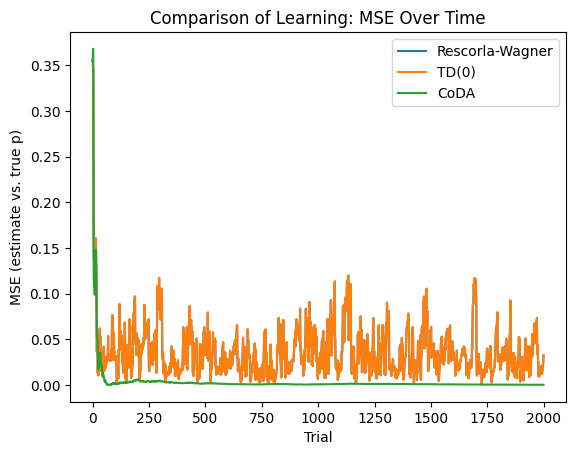

Final MSE after 2000 trials:
  Rescorla-Wagner: 0.03231059651611304
  TD(0):           0.03231059651611304
  CoDA:            0.0001839848903949324

True reward probabilities: [0.2, 0.5, 0.8, 0.7]
RW final V: [0.39267885 0.42649467 0.99735031 0.91855678]
TD final Q: [0.39267885 0.42649467 0.99735031 0.91855678]
CoDA final V: [0.20523867 0.50876252 0.79675934 0.67507587]


In [29]:
import numpy as np
import matplotlib.pyplot as plt


# -----------------------------------------------------------------
# 1) Multi-Stimulus Environment
# -----------------------------------------------------------------
class MultiStimulusEnvironment:
    """
    On each trial, randomly selects one of n_stimuli, then returns reward=1 with prob p[i].
    """
    def __init__(self, reward_probs, seed=None):
        """
        Args:
            reward_probs (list or np.array): Probability of reward for each stimulus i.
            seed (int): Optional random seed for reproducibility.
        """
        self.reward_probs = np.array(reward_probs)
        self.n_stimuli = len(self.reward_probs)
        self.rng = np.random.default_rng(seed)

    def step(self):
        """
        Randomly pick a stimulus, then sample a reward from Bernoulli(p[stimulus_idx]).

        Returns:
            stimulus_idx (int)
            reward (0 or 1)
        """
        # Choose a stimulus at random (uniform)
        stimulus_idx = self.rng.integers(0, self.n_stimuli)
        p = self.reward_probs[stimulus_idx]
        reward = 1 if self.rng.random() < p else 0
        return stimulus_idx, reward


# -----------------------------------------------------------------
# 2) Rescorla-Wagner for Multiple Stimuli
# -----------------------------------------------------------------
class RescorlaWagnerMulti:
    """
    A simple Rescorla-Wagner learner with separate V[i] for each stimulus.
    """
    def __init__(self, n_stimuli, alpha=0.3, init_value=0.0):
        """
        Args:
            n_stimuli (int)
            alpha (float): RW learning rate
            init_value (float): initial value for V
        """
        self.n_stimuli = n_stimuli
        self.alpha = alpha
        self.V = np.full(n_stimuli, init_value, dtype=float)

    def update(self, stimulus_idx, reward):
        """
        V[i] <- V[i] + alpha * (reward - V[i]) for the chosen stimulus.
        """
        prediction_error = reward - self.V[stimulus_idx]
        self.V[stimulus_idx] += self.alpha * prediction_error


# -----------------------------------------------------------------
# 3) TD(0) for Multiple Stimuli (single-step)
# -----------------------------------------------------------------
class TDMulti:
    """
    A single-step TD agent, basically the same update as RW in a bandit scenario.
    """
    def __init__(self, n_stimuli, alpha=0.3, init_value=0.0):
        self.n_stimuli = n_stimuli
        self.alpha = alpha
        self.Q = np.full(n_stimuli, init_value, dtype=float)

    def update(self, stimulus_idx, reward):
        """
        Q[stimulus_idx] += alpha * (reward - Q[stimulus_idx])
        """
        td_error = reward - self.Q[stimulus_idx]
        self.Q[stimulus_idx] += self.alpha * td_error


# -----------------------------------------------------------------
# 4) Your CoDAMulti Class
# -----------------------------------------------------------------
import numpy as np

class CoDAMulti:
    """
    A Contingency-dependent learner that tracks:
      - A[i]: count(stimulus i, reward=1)
      - B[i]: count(stimulus i, reward=0)
      - C[i]: count(no stimulus i, reward=1)
    Then computes V[i] = F_beta(specificity, sensitivity).
    """

    def __init__(self, n_stimuli, beta=1.0, init_value=0.0):
        """
        Args:
            n_stimuli (int): Number of stimuli/arms.
            beta (float): Weighs importance of sensitivity vs. specificity in F_beta.
                          (beta=1.0 -> standard F1, beta>1 emphasizes sensitivity.)
            init_value (float): initial count values for A, B, C, and initial V.
        """
        self.n_stimuli = n_stimuli
        self.beta = beta

        # Counters
        self.A = np.full(n_stimuli, init_value, dtype=float)  # Stimulus & reward
        self.B = np.full(n_stimuli, init_value, dtype=float)  # Stimulus & no reward
        self.C = np.full(n_stimuli, init_value, dtype=float)  # No stimulus & reward

        # The learned "contingency" measure for each stimulus
        self.V = np.full(n_stimuli, init_value, dtype=float)

    def get_specificity(self, A_val, B_val):
        """
        specificity = A / (A + B)
        where A= count(stimulus i, reward=1), B= count(stimulus i, reward=0).
        """
        denom = A_val + B_val
        return A_val / denom if denom > 0 else 0.0

    def get_sensitivity(self, A_val, C_val):
        """
        sensitivity = A / (A + C)
        where A= count(stimulus i, reward=1), C= count(no stimulus i, reward=1).
        """
        denom = A_val + C_val
        return A_val / denom if denom > 0 else 0.0

    def get_Fbeta(self, specificity, sensitivity, beta):
        """
        F_beta(specificity, sensitivity) = (1 + beta^2) * (spec * sens)
                                          / [beta^2 * spec + sens]
        """
        if (specificity + sensitivity) == 0:
            return 0.0
        return (1 + beta**2) * (specificity * sensitivity) / (beta**2 * specificity + sensitivity)

    def update(self, stimulus_idx, reward):
        """
        If reward=1, increment A[stimulus_idx], increment C for all other stimuli.
        If reward=0, increment B[stimulus_idx].
        Then recalc V[i] = F_beta(specificity_i, sensitivity_i, self.beta).
        """
        mask = np.arange(self.n_stimuli) != stimulus_idx

        # Update counters
        if reward == 1:
            self.A[stimulus_idx] += 1
            self.C[mask] += 1
        else:  # reward == 0
            self.B[stimulus_idx] += 1

        # Recompute each stimulus's V as F_beta of (specificity, sensitivity)
        for i in range(self.n_stimuli):
            spec = self.get_specificity(self.A[i], self.B[i])
            sens = self.get_sensitivity(self.A[i], self.C[i])
            self.V[i] = self.get_Fbeta(spec, sens, self.beta)



# -----------------------------------------------------------------
# 5) Run a Simulation Comparing the Three Agents
# -----------------------------------------------------------------
def run_experiment(agent, env, n_trials=1000):
    """
    Each trial:
      - environment picks a stimulus randomly
      - sample reward
      - agent updates
    We'll track the agent's estimates after each trial to compute MSE w.r.t. the true p_i.
    """
    n_stimuli = env.n_stimuli

    # Bookkeeping
    estimates_over_time = np.zeros((n_trials, n_stimuli))
    mse_over_time = np.zeros(n_trials)

    for t in range(n_trials):
        stim_idx, reward = env.step()
        agent.update(stim_idx, reward)

        # Current agent "estimates"
        if isinstance(agent, RescorlaWagnerMulti):
            estimates = agent.V
        elif isinstance(agent, TDMulti):
            estimates = agent.Q
        elif isinstance(agent, CoDAMulti):
            estimates = agent.V
        else:
            raise ValueError("Unknown agent type")

        estimates_over_time[t] = estimates

        # Mean squared error (MSE) vs. ground truth
        # Agent's 'estimates' vs. env.reward_probs (the true p_i)
        mse = np.mean((estimates - env.reward_probs) ** 2)
        mse_over_time[t] = mse

    return estimates_over_time, mse_over_time


def main():
    # True reward probabilities for each stimulus
    reward_probs = [0.2, 0.5, 0.8, 0.7]
    n_stimuli = len(reward_probs)

    # Make environment
    env_seed = 42
    env_rw = MultiStimulusEnvironment(reward_probs, seed=env_seed)
    env_td = MultiStimulusEnvironment(reward_probs, seed=env_seed)
    env_coda = MultiStimulusEnvironment(reward_probs, seed=env_seed)

    n_trials = 2000

    # -------------------------
    # Agents
    # -------------------------
    alpha = 0.3  # for RW, TD
    rw_agent = RescorlaWagnerMulti(n_stimuli, alpha=alpha, init_value=0.0)
    td_agent = TDMulti(n_stimuli, alpha=alpha, init_value=0.0)
    coda_agent = CoDAMulti(n_stimuli, init_value=0.0, beta=0.1)

    # -------------------------
    # Run each agent
    # -------------------------
    _, rw_mse = run_experiment(rw_agent, env_rw, n_trials)
    _, td_mse = run_experiment(td_agent, env_td, n_trials)
    _, coda_mse = run_experiment(coda_agent, env_coda, n_trials)

    # -------------------------
    # Compare MSE over time
    # -------------------------
    x = np.arange(n_trials)
    plt.plot(x, rw_mse, label="Rescorla-Wagner")
    plt.plot(x, td_mse, label="TD(0)")
    plt.plot(x, coda_mse, label="CoDA")
    plt.xlabel("Trial")
    plt.ylabel("MSE (estimate vs. true p)")
    plt.title("Comparison of Learning: MSE Over Time")
    plt.legend()
    plt.show()

    # Print final MSE
    print("Final MSE after", n_trials, "trials:")
    print("  Rescorla-Wagner:", rw_mse[-1])
    print("  TD(0):          ", td_mse[-1])
    print("  CoDA:           ", coda_mse[-1])

    # Print final estimates
    print("\nTrue reward probabilities:", reward_probs)
    print("RW final V:", rw_agent.V)
    print("TD final Q:", td_agent.Q)
    print("CoDA final V:", coda_agent.V)

if __name__ == "__main__":
    main()


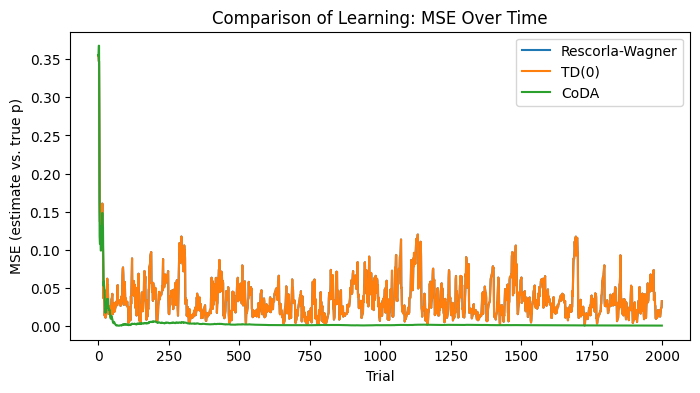

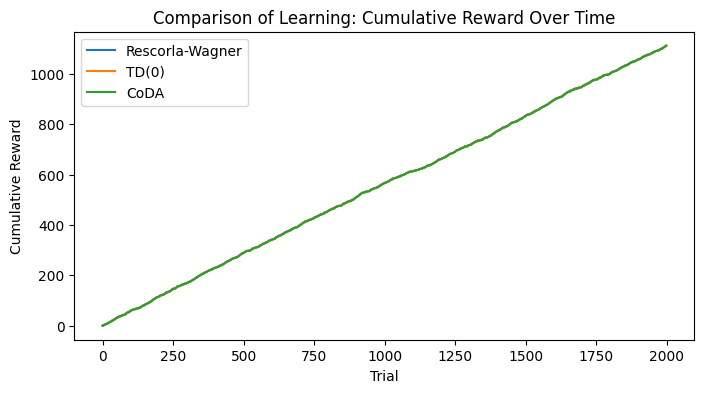

Final MSE after 2000 trials:
  Rescorla-Wagner: 0.03231059651611304
  TD(0):           0.03231059651611304
  CoDA:            0.0001839848903949324

Total (final) reward collected:
  Rescorla-Wagner: 1111.0
  TD(0):           1111.0
  CoDA:            1111.0

True reward probabilities: [0.2, 0.5, 0.8, 0.7]
RW final V: [0.39267885 0.42649467 0.99735031 0.91855678]
TD final Q: [0.39267885 0.42649467 0.99735031 0.91855678]
CoDA final V: [0.20523867 0.50876252 0.79675934 0.67507587]


In [30]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------------
# 1) Multi-Stimulus Environment
# -----------------------------------------------------------------
class MultiStimulusEnvironment:
    """
    On each trial, randomly selects one of n_stimuli, then returns reward=1 with prob p[i].
    """
    def __init__(self, reward_probs, seed=None):
        """
        Args:
            reward_probs (list or np.array): Probability of reward for each stimulus i.
            seed (int): Optional random seed for reproducibility.
        """
        self.reward_probs = np.array(reward_probs)
        self.n_stimuli = len(self.reward_probs)
        self.rng = np.random.default_rng(seed)

    def step(self):
        """
        Randomly pick a stimulus (uniform), then sample a reward from Bernoulli(p[stimulus_idx]).

        Returns:
            stimulus_idx (int)
            reward (0 or 1)
        """
        # Choose a stimulus at random
        stimulus_idx = self.rng.integers(0, self.n_stimuli)
        p = self.reward_probs[stimulus_idx]
        reward = 1 if self.rng.random() < p else 0
        return stimulus_idx, reward


# -----------------------------------------------------------------
# 2) Rescorla-Wagner for Multiple Stimuli
# -----------------------------------------------------------------
class RescorlaWagnerMulti:
    """
    A simple Rescorla-Wagner learner with separate V[i] for each stimulus.
    """
    def __init__(self, n_stimuli, alpha=0.3, init_value=0.0):
        """
        Args:
            n_stimuli (int)
            alpha (float): RW learning rate
            init_value (float): initial value for V
        """
        self.n_stimuli = n_stimuli
        self.alpha = alpha
        self.V = np.full(n_stimuli, init_value, dtype=float)

    def update(self, stimulus_idx, reward):
        """
        V[stimulus_idx] <- V[stimulus_idx] + alpha * (reward - V[stimulus_idx])
        """
        prediction_error = reward - self.V[stimulus_idx]
        self.V[stimulus_idx] += self.alpha * prediction_error


# -----------------------------------------------------------------
# 3) TD(0) for Multiple Stimuli (single-step)
# -----------------------------------------------------------------
class TDMulti:
    """
    A single-step TD agent, basically the same update as RW in a bandit scenario.
    """
    def __init__(self, n_stimuli, alpha=0.3, init_value=0.0):
        self.n_stimuli = n_stimuli
        self.alpha = alpha
        self.Q = np.full(n_stimuli, init_value, dtype=float)

    def update(self, stimulus_idx, reward):
        """
        Q[stimulus_idx] += alpha * (reward - Q[stimulus_idx])
        """
        td_error = reward - self.Q[stimulus_idx]
        self.Q[stimulus_idx] += self.alpha * td_error


# -----------------------------------------------------------------
# 4) Your CoDAMulti Class (with F_beta)
# -----------------------------------------------------------------
class CoDAMulti:
    """
    A Contingency-dependent learner that tracks:
      - A[i]: count(stimulus i, reward=1)
      - B[i]: count(stimulus i, reward=0)
      - C[i]: count(no stimulus i, reward=1)
    Then computes V[i] = F_beta(specificity, sensitivity).
    """
    def __init__(self, n_stimuli, beta=1.0, init_value=0.0):
        """
        Args:
            n_stimuli (int): Number of stimuli/arms.
            beta (float): Weighs importance of sensitivity vs. specificity in F_beta.
                          (beta=1.0 -> standard F1, beta>1 emphasizes sensitivity.)
            init_value (float): initial count values for A, B, C, and initial V.
        """
        self.n_stimuli = n_stimuli
        self.beta = beta

        # Counters
        self.A = np.full(n_stimuli, init_value, dtype=float)  # Stimulus & reward
        self.B = np.full(n_stimuli, init_value, dtype=float)  # Stimulus & no reward
        self.C = np.full(n_stimuli, init_value, dtype=float)  # No stimulus & reward

        # The learned "contingency" measure for each stimulus
        self.V = np.full(n_stimuli, init_value, dtype=float)

    def get_specificity(self, A_val, B_val):
        denom = A_val + B_val
        return A_val / denom if denom > 0 else 0.0

    def get_sensitivity(self, A_val, C_val):
        denom = A_val + C_val
        return A_val / denom if denom > 0 else 0.0

    def get_Fbeta(self, specificity, sensitivity, beta):
        """
        F_beta(specificity, sensitivity) = (1 + beta^2) * (spec * sens)
                                          / [beta^2 * spec + sens]
        """
        if (specificity + sensitivity) == 0:
            return 0.0
        return (1 + beta**2) * (specificity * sensitivity) / (beta**2 * specificity + sensitivity)

    def update(self, stimulus_idx, reward):
        """
        If reward=1, increment A[stimulus_idx], increment C for all other stimuli.
        If reward=0, increment B[stimulus_idx].
        Then recalc V[i] = F_beta(specificity_i, sensitivity_i, self.beta).
        """
        mask = np.arange(self.n_stimuli) != stimulus_idx

        if reward == 1:
            self.A[stimulus_idx] += 1
            self.C[mask] += 1
        else:  # reward == 0
            self.B[stimulus_idx] += 1

        # Recompute each stimulus's V as F_beta of (specificity, sensitivity)
        for i in range(self.n_stimuli):
            spec = self.get_specificity(self.A[i], self.B[i])
            sens = self.get_sensitivity(self.A[i], self.C[i])
            self.V[i] = self.get_Fbeta(spec, sens, self.beta)


# -----------------------------------------------------------------
# 5) Run a Simulation + Return Cumulative Reward
# -----------------------------------------------------------------
def run_experiment(agent, env, n_trials=1000):
    """
    For each trial:
      - environment picks a stimulus randomly
      - we get reward
      - agent updates
    We'll track:
      - the agent's estimates for each stimulus
      - MSE vs. the true p_i
      - *cumulative reward* (sum of rewards up to each trial)
    """
    n_stimuli = env.n_stimuli

    # Bookkeeping
    estimates_over_time = np.zeros((n_trials, n_stimuli))
    mse_over_time = np.zeros(n_trials)
    rewards = np.zeros(n_trials)  # store each trial's reward

    for t in range(n_trials):
        stim_idx, reward = env.step()  # environment picks a stimulus, returns reward
        agent.update(stim_idx, reward)

        # Identify agent's current "estimates" array
        if isinstance(agent, RescorlaWagnerMulti):
            estimates = agent.V
        elif isinstance(agent, TDMulti):
            estimates = agent.Q
        elif isinstance(agent, CoDAMulti):
            estimates = agent.V
        else:
            raise ValueError("Unknown agent type")

        # Store
        estimates_over_time[t] = estimates
        mse_over_time[t] = np.mean((estimates - env.reward_probs)**2)
        rewards[t] = reward

    # Also compute cumulative reward
    cumulative_reward = np.cumsum(rewards)

    # Return the time-series for estimates (unused here), MSE, and cumulative reward
    return estimates_over_time, mse_over_time, cumulative_reward


def main():
    # True reward probabilities for each stimulus
    reward_probs = [0.2, 0.5, 0.8, 0.7]
    n_stimuli = len(reward_probs)

    # Make environment
    env_seed = 42
    env_rw = MultiStimulusEnvironment(reward_probs, seed=env_seed)
    env_td = MultiStimulusEnvironment(reward_probs, seed=env_seed)
    env_coda = MultiStimulusEnvironment(reward_probs, seed=env_seed)

    n_trials = 2000

    # Agents
    alpha = 0.3  # RW/TD
    beta = 0.1   # CoDA weighting
    rw_agent = RescorlaWagnerMulti(n_stimuli, alpha=alpha, init_value=0.0)
    td_agent = TDMulti(n_stimuli, alpha=alpha, init_value=0.0)
    coda_agent = CoDAMulti(n_stimuli, beta=beta, init_value=0.0)

    # Run each agent
    _, rw_mse, rw_cum_rewards = run_experiment(rw_agent, env_rw, n_trials)
    _, td_mse, td_cum_rewards = run_experiment(td_agent, env_td, n_trials)
    _, coda_mse, coda_cum_rewards = run_experiment(coda_agent, env_coda, n_trials)

    # Plot MSE
    plt.figure(figsize=(8,4))
    plt.plot(rw_mse, label="Rescorla-Wagner")
    plt.plot(td_mse, label="TD(0)")
    plt.plot(coda_mse, label="CoDA")
    plt.xlabel("Trial")
    plt.ylabel("MSE (estimate vs. true p)")
    plt.title("Comparison of Learning: MSE Over Time")
    plt.legend()
    plt.show()

    # Plot Cumulative Reward
    plt.figure(figsize=(8,4))
    plt.plot(rw_cum_rewards, label="Rescorla-Wagner")
    plt.plot(td_cum_rewards, label="TD(0)")
    plt.plot(coda_cum_rewards, label="CoDA")
    plt.xlabel("Trial")
    plt.ylabel("Cumulative Reward")
    plt.title("Comparison of Learning: Cumulative Reward Over Time")
    plt.legend()
    plt.show()

    # Print final results
    print("Final MSE after", n_trials, "trials:")
    print("  Rescorla-Wagner:", rw_mse[-1])
    print("  TD(0):          ", td_mse[-1])
    print("  CoDA:           ", coda_mse[-1])

    print("\nTotal (final) reward collected:")
    print("  Rescorla-Wagner:", rw_cum_rewards[-1])
    print("  TD(0):          ", td_cum_rewards[-1])
    print("  CoDA:           ", coda_cum_rewards[-1])

    # Print final estimates
    print("\nTrue reward probabilities:", reward_probs)
    print("RW final V:", rw_agent.V)
    print("TD final Q:", td_agent.Q)
    print("CoDA final V:", coda_agent.V)


if __name__ == "__main__":
    main()


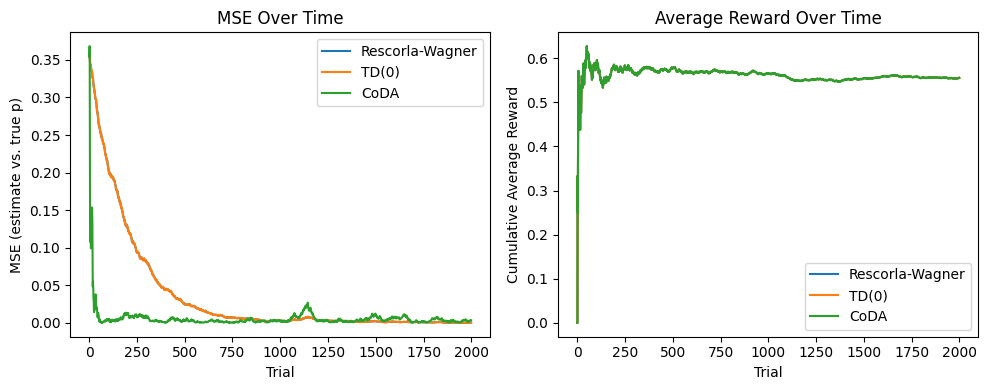

Final MSE after 2000 trials:
  Rescorla-Wagner: 0.0003017214854817723
  TD(0):           0.0003017214854817723
  CoDA:            0.0035928619073517278

Final average reward (last 100 trials):
  RW:    0.5551213322858216
  TD:    0.5551213322858216
  CoDA:  0.5551213322858216

True reward probabilities: [0.2, 0.5, 0.8, 0.7]
RW final V: [0.19591332 0.47935138 0.82229361 0.71633446]
TD final Q: [0.19591332 0.47935138 0.82229361 0.71633446]
CoDA final V: [0.25397746 0.42526174 0.86827519 0.73479329]


In [45]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------------
# 1) Multi-Stimulus Environment
# -----------------------------------------------------------------
class MultiStimulusEnvironment:
    """
    On each trial, randomly selects one of n_stimuli, then returns reward=1 with prob p[i].
    """
    def __init__(self, reward_probs, seed=None):
        """
        Args:
            reward_probs (list or np.array): Probability of reward for each stimulus i.
            seed (int): Optional random seed for reproducibility.
        """
        self.reward_probs = np.array(reward_probs)
        self.n_stimuli = len(self.reward_probs)
        self.rng = np.random.default_rng(seed)

    def step(self):
        """
        Randomly pick a stimulus, then sample a reward from Bernoulli(p[stimulus_idx]).

        Returns:
            stimulus_idx (int)
            reward (0 or 1)
        """
        # Choose a stimulus at random (uniformly)
        stimulus_idx = self.rng.integers(0, self.n_stimuli)
        p = self.reward_probs[stimulus_idx]
        reward = 1 if self.rng.random() < p else 0
        return stimulus_idx, reward


# -----------------------------------------------------------------
# 2) Rescorla-Wagner for Multiple Stimuli
# -----------------------------------------------------------------
class RescorlaWagnerMulti:
    """
    A simple Rescorla-Wagner learner with separate V[i] for each stimulus.
    """
    def __init__(self, n_stimuli, alpha=0.3, init_value=0.0):
        """
        Args:
            n_stimuli (int)
            alpha (float): RW learning rate
            init_value (float): initial value for V
        """
        self.n_stimuli = n_stimuli
        self.alpha = alpha
        self.V = np.full(n_stimuli, init_value, dtype=float)

    def update(self, stimulus_idx, reward):
        """
        V[stimulus_idx] <- V[stimulus_idx] + alpha * (reward - V[stimulus_idx])
        """
        prediction_error = reward - self.V[stimulus_idx]
        self.V[stimulus_idx] += self.alpha * prediction_error


# -----------------------------------------------------------------
# 3) TD(0) for Multiple Stimuli (single-step)
# -----------------------------------------------------------------
class TDMulti:
    """
    A single-step TD agent, basically the same update as RW in a bandit scenario.
    """
    def __init__(self, n_stimuli, alpha=0.3, init_value=0.0):
        self.n_stimuli = n_stimuli
        self.alpha = alpha
        self.Q = np.full(n_stimuli, init_value, dtype=float)

    def update(self, stimulus_idx, reward):
        """
        Q[stimulus_idx] += alpha * (reward - Q[stimulus_idx])
        """
        td_error = reward - self.Q[stimulus_idx]
        self.Q[stimulus_idx] += self.alpha * td_error


# -----------------------------------------------------------------
# 4) CoDAMulti Class (with F_beta)
# -----------------------------------------------------------------
class CoDAMulti:
    """
    A Contingency-dependent learner with exponential decay.
    Each update:
      1) A, B, C are multiplied by gamma < 1.
      2) We add +1 to the relevant counter(s) for the current event.
      3) Recompute V[i] = F_beta(specificity, sensitivity).

    This means older events become exponentially less impactful.
    """

    def __init__(self, n_stimuli, beta=1.0, gamma=0.99, init_value=0.0):
        """
        Args:
            n_stimuli (int): number of stimuli/arms.
            beta (float): for F_beta measure (beta=1 => standard F1).
            gamma (float): decay factor in [0,1). E.g. 0.99 => older data retains 99% weight per step.
            init_value (float): initial counters (A,B,C) and initial V.
        """
        self.n_stimuli = n_stimuli
        self.beta = beta
        self.gamma = gamma

        # Initialize counters
        self.A = np.full(n_stimuli, init_value, dtype=float)
        self.B = np.full(n_stimuli, init_value, dtype=float)
        self.C = np.full(n_stimuli, init_value, dtype=float)

        # Final contingency measure for each stimulus
        self.V = np.full(n_stimuli, init_value, dtype=float)

    def _get_specificity(self, A_val, B_val):
        denom = A_val + B_val
        return A_val / denom if denom > 0 else 0.0

    def _get_sensitivity(self, A_val, C_val):
        denom = A_val + C_val
        return A_val / denom if denom > 0 else 0.0

    def _get_Fbeta(self, specificity, sensitivity):
        if specificity + sensitivity == 0:
            return 0.0
        beta_sq = self.beta ** 2
        return (1 + beta_sq) * specificity * sensitivity / (beta_sq * specificity + sensitivity)

    def update(self, chosen_arm, reward):
        """
        1) Exponentially decay the counters A, B, C.
        2) Increment A if chosen_arm got reward=1, or B if chosen_arm got reward=0.
           Also increment C for the other arms if reward=1.
        3) Recompute V[i] for each arm using F_beta(specificity, sensitivity).
        """
        # 1) Exponential decay of all counters
        self.A *= self.gamma
        self.B *= self.gamma
        self.C *= self.gamma

        # 2) Add current trial's contribution
        mask = np.arange(self.n_stimuli) != chosen_arm
        if reward == 1:
            self.A[chosen_arm] += 1
            self.C[mask] += 1
        else:
            self.B[chosen_arm] += 1

        # 3) Recompute V for each arm
        for i in range(self.n_stimuli):
            spec = self._get_specificity(self.A[i], self.B[i])
            sens = self._get_sensitivity(self.A[i], self.C[i])
            self.V[i] = self._get_Fbeta(spec, sens)


# -----------------------------------------------------------------
# 5) Run a Simulation + Return cumulative average reward
# -----------------------------------------------------------------
def run_experiment(agent, env, n_trials=1000):
    """
    For each trial:
      - env picks a stimulus randomly
      - we get reward
      - agent updates
    We track:
      - the agent's estimates for each stimulus
      - MSE vs. the true p_i
      - cumulative *average* reward
    """
    n_stimuli = env.n_stimuli

    # Bookkeeping
    estimates_over_time = np.zeros((n_trials, n_stimuli))
    mse_over_time = np.zeros(n_trials)
    rewards = np.zeros(n_trials)

    for t in range(n_trials):
        stim_idx, reward = env.step()
        agent.update(stim_idx, reward)

        # Identify agent's current estimate array
        if isinstance(agent, RescorlaWagnerMulti):
            estimates = agent.V
        elif isinstance(agent, TDMulti):
            estimates = agent.Q
        elif isinstance(agent, CoDAMulti):
            estimates = agent.V
        else:
            raise ValueError("Unknown agent type")

        estimates_over_time[t] = estimates
        mse_over_time[t] = np.mean((estimates - env.reward_probs)**2)
        rewards[t] = reward

    # Cumulative average reward
    cumulative_avg_reward = np.cumsum(rewards) / (np.arange(n_trials) + 1)

    return estimates_over_time, mse_over_time, cumulative_avg_reward


def main():
    # True reward probabilities for each stimulus
    reward_probs = [0.2, 0.5, 0.8, 0.7]
    n_stimuli = len(reward_probs)

    # Make environment
    env_seed = 42
    env_rw = MultiStimulusEnvironment(reward_probs, seed=env_seed)
    env_td = MultiStimulusEnvironment(reward_probs, seed=env_seed)
    env_coda = MultiStimulusEnvironment(reward_probs, seed=env_seed)

    n_trials = 2000

    # Agents
    # alpha = 0.3  # RW/TD
    alpha = 0.01  # RW/TD
    beta = 0.0   # CoDA weighting
    gamma = 0.99 # CoDA memory decay
    rw_agent = RescorlaWagnerMulti(n_stimuli, alpha=alpha, init_value=0.0)
    td_agent = TDMulti(n_stimuli, alpha=alpha, init_value=0.0)
    coda_agent = CoDAMulti(n_stimuli, beta=beta, gamma=gamma, init_value=0.0)

    # Run each agent
    _, rw_mse, rw_cum_avg = run_experiment(rw_agent, env_rw, n_trials)
    _, td_mse, td_cum_avg = run_experiment(td_agent, env_td, n_trials)
    _, coda_mse, coda_cum_avg = run_experiment(coda_agent, env_coda, n_trials)

    # Plot MSE
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(rw_mse, label="Rescorla-Wagner")
    plt.plot(td_mse, label="TD(0)")
    plt.plot(coda_mse, label="CoDA")
    plt.xlabel("Trial")
    plt.ylabel("MSE (estimate vs. true p)")
    plt.title("MSE Over Time")
    plt.legend()

    # Plot Cumulative Average Reward
    plt.subplot(1,2,2)
    plt.plot(rw_cum_avg, label="Rescorla-Wagner")
    plt.plot(td_cum_avg, label="TD(0)")
    plt.plot(coda_cum_avg, label="CoDA")
    plt.xlabel("Trial")
    plt.ylabel("Cumulative Average Reward")
    plt.title("Average Reward Over Time")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print final results
    print("Final MSE after", n_trials, "trials:")
    print("  Rescorla-Wagner:", rw_mse[-1])
    print("  TD(0):          ", td_mse[-1])
    print("  CoDA:           ", coda_mse[-1])

    print("\nFinal average reward (last 100 trials):")
    print("  RW:   ", np.mean(rw_cum_avg[-100:]))
    print("  TD:   ", np.mean(td_cum_avg[-100:]))
    print("  CoDA: ", np.mean(coda_cum_avg[-100:]))

    print("\nTrue reward probabilities:", reward_probs)
    print("RW final V:", rw_agent.V)
    print("TD final Q:", td_agent.Q)
    print("CoDA final V:", coda_agent.V)


if __name__ == "__main__":
    main()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set up CS+ trials with different probabilities of US
n_trials = 40
cs_present = np.ones(n_trials)
us_prob_prospective = np.concatenate([
    np.full(20, 1.0),  # Strong contingency early
    np.full(20, 0.2)   # Weak contingency later
])
us_outcomes = np.random.binomial(1, us_prob_prospective)

# Prospective learner: updates P(US|CS)
prospective_estimate = []
alpha = 0.1
p = 0.5  # initial estimate
for us in us_outcomes:
    p += alpha * (us - p)
    prospective_estimate.append(p)

# Retrospective learner: updates P(CS|US) after seeing US
retrospective_estimate = []
cs_given_us = []
cs_history = []
us_history = []
for t in range(n_trials):
    cs = cs_present[t]
    us = us_outcomes[t]
    cs_history.append(cs)
    us_history.append(us)
    if sum(us_history) > 0:
        cs_given_us_prob = sum(
            c for c, u in zip(cs_history, us_history) if u == 1
        ) / sum(us_history)
    else:
        cs_given_us_prob = 0.5
    retrospective_estimate.append(cs_given_us_prob)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(prospective_estimate, label="Prospective: P(US|CS)", lw=2)
plt.plot(retrospective_estimate, label="Retrospective: P(CS|US)", lw=2)
plt.axvline(20, linestyle='--', color='gray', label="Contingency Shift")
plt.xlabel("Trial")
plt.ylabel("Estimated Probability")
plt.title("Prospective vs Retrospective Learning")
plt.legend()
plt.tight_layout()
plt.show()


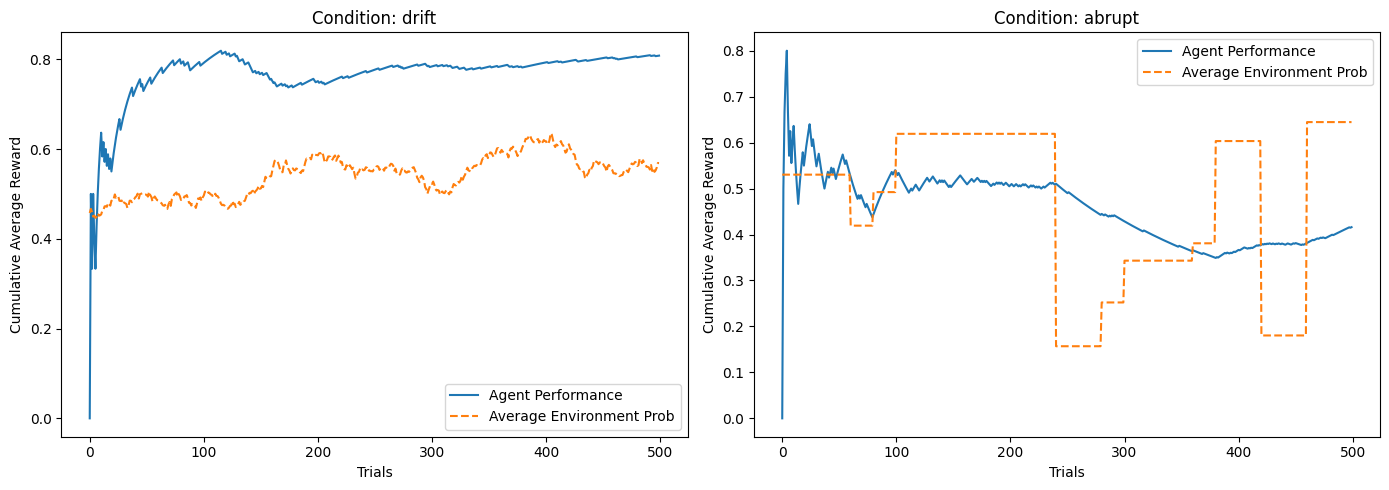

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class ContingencyState:
    def __init__(self):
        self.a = 1  # US|CS+ counts
        self.b = 1  # No-US|CS+ counts
        self.c = 1  # US|CS- counts (for retrospective)
        self.prospective_history = []
        self.retrospective_history = []
        self.active = True

    def update(self, reward):
        if reward:
            self.a += 1
        else:
            self.b += 1

    def get_prospective(self):
        return self.a / (self.a + self.b)

    def get_retrospective(self):
        return self.a / (self.a + self.c)

class ContingencyAgent:
    def __init__(self, n_arms, window=10, prospective_thresh=0.3, retrospective_thresh=0.2):
        self.arms = {i: [ContingencyState()] for i in range(n_arms)}
        self.window = window
        self.prospective_thresh = prospective_thresh
        self.retrospective_thresh = retrospective_thresh

    def select_action(self):
        arm_values = [np.mean([state.get_prospective() for state in states if state.active])
                      for states in self.arms.values()]
        return np.argmax(arm_values)

    def update(self, chosen_arm, reward):
        states = self.arms[chosen_arm]
        current_state = states[-1]
        current_state.update(reward)

        # Check prospective contingency change
        if len(current_state.prospective_history) >= self.window:
            prev_contingency = np.mean(current_state.prospective_history[-self.window:])
            current_contingency = current_state.get_prospective()

            if abs(current_contingency - prev_contingency) > self.prospective_thresh:
                # Split a new clone state
                states.append(ContingencyState())

        current_state.prospective_history.append(current_state.get_prospective())

        # Check retrospective contingency
        for state in states[:-1]:  # Don't deactivate the most recent clone immediately
            state.retrospective_history.append(state.get_retrospective())
            if len(state.retrospective_history) >= self.window:
                if np.mean(state.retrospective_history[-self.window:]) < self.retrospective_thresh:
                    state.active = False

# Environment simulation
def generate_bandit_probs(n_trials, n_arms, condition='drift'):
    probs = np.zeros((n_trials, n_arms))
    if condition == 'drift':
        probs[0, :] = np.random.rand(n_arms)
        for t in range(1, n_trials):
            probs[t, :] = probs[t-1, :] + np.random.randn(n_arms) * 0.01
            probs[t, :] = np.clip(probs[t, :], 0.1, 0.9)
    elif condition == 'abrupt':
        probs[0, :] = np.random.rand(n_arms)
        change_points = np.sort(np.random.choice(np.arange(20, n_trials-20, 20), size=n_trials//50, replace=False))
        for i in range(1, n_trials):
            probs[i, :] = probs[i-1, :]
            if i in change_points:
                probs[i, :] = np.random.rand(n_arms)
    return probs

# Simulation parameters
n_trials = 500
n_arms = 3

conditions = ['drift', 'abrupt']

# Run simulation
fig, axes = plt.subplots(1, 2, figsize=(14,5))

for idx, condition in enumerate(conditions):
    env_probs = generate_bandit_probs(n_trials, n_arms, condition)
    agent = ContingencyAgent(n_arms)

    rewards = np.zeros(n_trials)

    for t in range(n_trials):
        action = agent.select_action()
        reward = np.random.rand() < env_probs[t, action]
        rewards[t] = reward
        agent.update(action, reward)

    # Plot results
    axes[idx].plot(np.cumsum(rewards)/np.arange(1, n_trials+1), label='Agent Performance')
    axes[idx].plot(np.mean(env_probs, axis=1), label='Average Environment Prob', linestyle='--')
    axes[idx].set_title(f"Condition: {condition}")
    axes[idx].set_xlabel('Trials')
    axes[idx].set_ylabel('Cumulative Average Reward')
    axes[idx].legend()

plt.tight_layout()
plt.show()


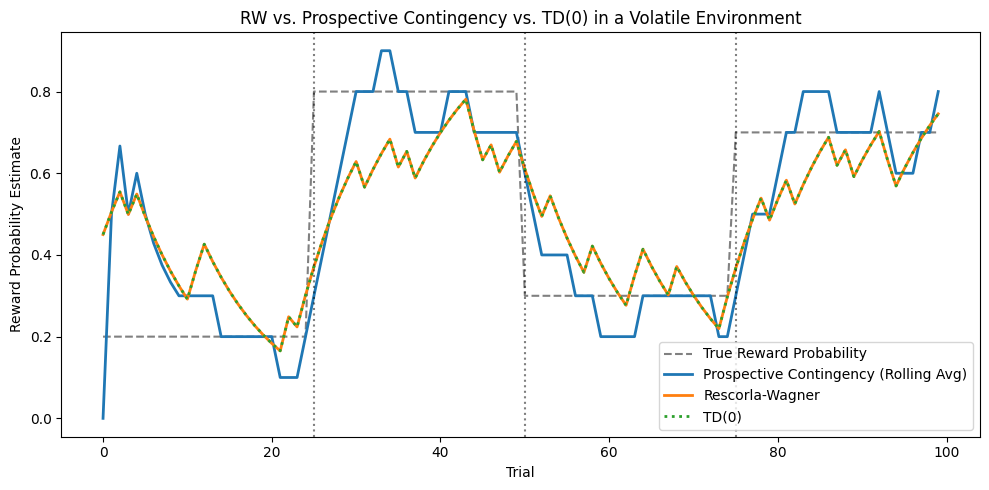

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_trials = 100
switch_points = [0, 25, 50, 75]
reward_probs = [0.2, 0.8, 0.3, 0.7]

# Build reward probability schedule
reward_schedule = np.zeros(n_trials)
for i in range(len(switch_points)):
    start = switch_points[i]
    end = switch_points[i + 1] if i + 1 < len(switch_points) else n_trials
    reward_schedule[start:end] = reward_probs[i]

# Simulate rewards
rewards = np.random.binomial(1, reward_schedule)

# Prospective contingency (rolling average)
window = 10
prospective = []
for t in range(n_trials):
    start = max(0, t - window + 1)
    recent_rewards = rewards[start:t + 1]
    prospective.append(np.mean(recent_rewards) if len(recent_rewards) > 0 else 0.5)

# Rescorla-Wagner simulation
alpha_rw = 0.1
V_rw = 0.5
rw_estimates = []
for reward in rewards:
    V_rw += alpha_rw * (reward - V_rw)
    rw_estimates.append(V_rw)

# TD(0) simulation
alpha_td = 0.1
V_td = 0.5
td_estimates = []
for reward in rewards:
    V_td += alpha_td * (reward - V_td)
    td_estimates.append(V_td)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(reward_schedule, label="True Reward Probability", linestyle='--', color='gray')
plt.plot(prospective, label="Prospective Contingency (Rolling Avg)", lw=2)
plt.plot(rw_estimates, label="Rescorla-Wagner", lw=2)
plt.plot(td_estimates, label="TD(0)", lw=2, linestyle=':')
for sp in switch_points[1:]:
    plt.axvline(sp, linestyle=':', color='black', alpha=0.5)
plt.xlabel("Trial")
plt.ylabel("Reward Probability Estimate")
plt.title("RW vs. Prospective Contingency vs. TD(0) in a Volatile Environment")
plt.legend()
plt.tight_layout()
plt.show()
